#### loading the libraries

In [1]:
import os
import sys
import pyvista as pv
import trimesh as tm
import numpy as np
import topogenesis as tg
import pickle as pk
sys.path.append(os.path.realpath('..\..')) # no idea how or why this is not working without adding this to the path TODO: learn about path etc.
from notebooks.resources import RES as res
import pygmo as pg

#### loading the meshes and vectors

In [2]:
# load base lattice CSV file
lattice_path = os.path.relpath('../../data/macrovoxels.csv')
macro_lattice = tg.lattice_from_csv(lattice_path)

# load environment
environment_path = os.path.relpath("../../data/movedcontext.obj") 
environment_mesh = tm.load(environment_path)

# load solar vectors
vectors = pk.load(open("../../data/sunvectors.pk", "rb"))

# load vector intensities
intensity_pv = pk.load(open("../../data/ghrval.pk", "rb")) # global horizontal radiation

# load vector intensities
intensity_dl = pk.load(open("../../data/dnival.pk", "rb")) # direct normal illuminance

#### defining target FSI, number of variables

In [3]:
goal_FSI = 3
num_var = macro_lattice.flatten().shape[0]

#### creating the class for running the optimization

In [4]:
class pygmo_optimize:

    # Number of dimensions
    def __init__(self, dim, reflattice, crit1_values, crit2_values, sunvectors, environment, targetFSI):
        self.dim = dim
        self.reflattice = reflattice
        self.crit1_values = crit1_values
        self.crit2_values = crit2_values
        self.sunvectors = sunvectors
        self.environment = environment
        self.targetFSI = targetFSI

    # Define objectives    
    def fitness(self, x):
        # PyGmo minimizes. To maximize, we need to invert our objective functions

        # global horizontal radiation on voxel roofs (PV potential) MAXIMIZE
        f1 = - res.crit_1_PV(x, self.reflattice, self.sunvectors, self.crit1_values, self.environment)[0]

        # direct normal illuminance on voxel facade (daylight potential) MAXIMIZE
        f2 = - res.crit_2_DL(x, self.reflattice, self.sunvectors, self.crit2_values, self.environment)[0]

        # relative compactness MINIMIZE
        f3 =   res.crit_3_RC(x, self.reflattice)

        # Floor Space Index deviation MAXIMIZE
        f4 = - res.crit_4_FSI(x, self.reflattice, self.targetFSI)

        return [f1, f2, f3, f4]
    
    # Return number of objectives
    def get_nobj(self):
        return 4

    # Return bounds of decision variables
    def get_bounds(self):
        return (np.full((self.dim,),0.),np.full((self.dim,),1.))

    # Return function name
    def get_name(self):
        return "Test function MAX"

In [5]:
# create User Defined Problem
prob = pg.problem(pygmo_optimize(
    dim= num_var, 
    reflattice= macro_lattice, 
    crit1_values= intensity_pv, 
    crit2_values= intensity_dl, 
    sunvectors= vectors, 
    environment= environment_mesh, 
    targetFSI= goal_FSI
    ))

In [6]:
# create population
pop = pg.population(prob, size=10)

# select algorithm --> ihs nsga2 maco for integers
# maco seems slow, unreliable
# nspso non dominated sorting particle swarm optimization
# ihs seems fastest but not always yields results that make sense
# nsga2 is most consistent with results, average speed

# TODO: continuous in stead of discrete/integer
algo = pg.algorithm(pg.nspso(gen=100))

# run optimization
pop = algo.evolve(pop)


In [25]:
class my_isl:

    def run_evolve(self, algo, pop):

        new_pop = algo.evolve(pop)

        return algo, new_pop

    def get_name(self):

        return "It's my island!"

isl = pg.island(algo = pg.nspso(100), prob = prob, udi = my_isl(), size=10)

In [43]:
def _evolve_func(algo, pop): # doctest : +SKIP

    new_pop = algo.evolve(pop)

    return algo, new_pop

class mp_island(object): # doctest : +SKIP

    def __init__(self):

        # Init the process pool, if necessary.

        mp_island.init_pool()


    def run_evolve(self, algo, pop):

        with mp_island._pool_lock:

            res = mp_island._pool.apply_async(_evolve_func, (algo, pop))

        return res.get()

In [45]:
archi = pg.archipelago(n = 5, algo = pg.nspso(100), prob = prob, pop_size = 10, udi = my_isl())

archi.evolve()

In [73]:
print(archi)

Number of islands: 5
Topology: Unconnected
Migration type: point-to-point
Migrant handling policy: preserve
Status: busy

Islands summaries:

	#  Type             Algo   Prob               Size  Status  
	------------------------------------------------------------
	0  It's my island!  NSPSO  Test function MAX  10    busy    
	1  It's my island!  NSPSO  Test function MAX  10    busy    
	2  It's my island!  NSPSO  Test function MAX  10    busy    
	3  It's my island!  NSPSO  Test function MAX  10    busy    
	4  It's my island!  NSPSO  Test function MAX  10    busy    



In [28]:
import matplotlib.pyplot as plt

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex='col', sharey='row', figsize=(15,15)) 

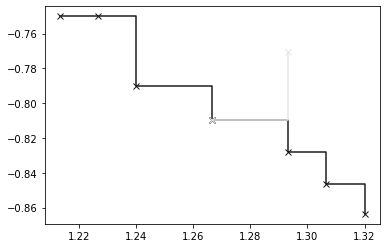

In [67]:
# extract results
fits, vecs = pop.get_f(), pop.get_x()

# extract and print non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

ax = pg.plot_non_dominated_fronts(fits,comp=[2,3], marker='x') # plotting the non dominated fronts #TODO: what exactly does this mean in this context

In [8]:
fits_path = os.path.relpath("../../data/fits_NSPSO_10x100_all.obj")
pk.dump(fits, open(fits_path, "wb"))

vecs_path = os.path.relpath("../../data/vecs_NSPSO_10x100_all.obj")
pk.dump(vecs, open(vecs_path, "wb"))

In [9]:
best = pg.sort_population_mo(points = fits)[0] # the best solutions (by population)

In [10]:
print("The best configuration is: \n", np.around(vecs[best]).astype(int), "\n It's fitness is: ", fits[best][0].astype(int), fits[best][1].astype(int), fits[best][2], fits[best][3], "\n This is population #", best)

The best configuration is: 
 [1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1
 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1
 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1
 0 1 0 0 0 1 1 0 1 1 1 1 0 1] 
 It's fitness is:  -2147483648 -2147483648 1.293333333333334 -0.828125 
 This is population # 0


In [11]:
np.count_nonzero(np.around(vecs[best]))

64

In [12]:
crit1, voxcrit1 = res.crit_1_PV(vecs[best], macro_lattice, vectors, intensity_pv, environment_mesh)
crit2, voxcrit2 = res.crit_2_DL(vecs[best], macro_lattice, vectors, intensity_pv, environment_mesh)
crit3 = res.crit_3_RC(vecs[best], macro_lattice)
crit4 = res.crit_4_FSI(vecs[best], macro_lattice, goal_FSI)

In [13]:
configuration = res.reshape_and_store_to_lattice(np.around(vecs[best]), macro_lattice)

In [14]:
meshesroof, _, _ = res.construct_horizontal_mesh(configuration, configuration.unit)
roofmesh = tm.util.concatenate(meshesroof)

meshesfacade, _, _ = res.construct_vertical_mesh(configuration, configuration.unit)
facademesh = tm.util.concatenate(meshesfacade)

In [15]:
# visualize configuration 
p = pv.Plotter(notebook=True)

# fast visualization of the lattice
configuration.fast_vis(p,opacity=0.1)
p.add_mesh(environment_mesh)
p.add_mesh(roofmesh, cmap='fire', scalars=np.repeat(voxcrit1,2))
p.add_mesh(facademesh, cmap='fire', scalars=np.repeat(voxcrit2,2))

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(788.6785661399646, 711.2621611399645, 723.5957336399646),
 (65.08283250000001, -12.333572500000002, 0.0),
 (0.0, 0.0, 1.0)]